In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import tensor
from utils.load_folktables import prepare_folktables, prepare_folktables_multattr
from humancompatible.train.constraints.constraint_fns import *
from fairret.statistic import *
from utils.network import SimpleNet

This notebook presents some useful plots based on the performance of the trained models.

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [ ]:
TASK = "income"
# TASK = 'employment'
STATE = "CA"

In [ ]:
sens_cols=[
    "MAR",
    # "SEX",
    # 'RAC1P',
    ]

(
    X_train,
    y_train,
    group_ind_train,
    group_onehot_train,
    sep_group_ind_train,
    X_test,
    y_test,
    group_ind_test,
    group_onehot_test,
    sep_group_ind_test,
    group_order
) = prepare_folktables_multattr(
    TASK,
    state=STATE.upper(),
    random_state=42,
    onehot=False,
    download=True,
    sens_cols=sens_cols,
    binarize=[None, None],
    stratify=False,
)

In [ ]:
group_codes = {
    "MAR": {1: "Mar", 2: "Wid", 3: "Div", 4: "Sep", 5:"Nev"},
    "SEX": {1: "M", 2: "F"},
    "RAC1P": {1: "W", 2: "B", 3: "AI", 4: "AN", 5: "AIAN", 6: "A", 7: "PA", 8: "OT", 9: "TW"}
}
groups_sep = [[int(g) for g in gr.split('_')] for gr in group_order]
group_names = [[group_codes[sens_cols[i]][c] for i, c in enumerate(gc)] for gc in groups_sep]
group_names = ['_'.join(g) for g in group_names]
group_names

['Mar', 'Wid', 'Div', 'Sep', 'Nev']

In [ ]:
device = "cuda" if torch.cuda.is_available() and False else "cpu"

In [ ]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)

X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)

**Load saved models**

In [ ]:
from itertools import product

constraints = {
    # 'abs_max_dev_from_overall_tpr': 0.02,
    "abs_diff_tpr": 0.02,
    # "abs_diff_fpr": 0.02,
    # 'abs_loss_equality': 0.02,
    # "loss_equality": 0.005,
    "unconstrained": 0.01,
}

dict_alg_names = {
    # "ssg-mar": "SSw MAR",
    # "sslalm-mar": "SSLALM MAR",
    "SGD-mar": "SGD MAR",
    "TorchSSLALM": "sslalm-torch",
    # "SSLALM": "sslalm",
    # "SSG": "SSw",
    # "SGD": "SGD",
    # "fairret": "SGD-Fairret",
}

DATASET = TASK + "_" + STATE
loaded_models = []

for constr, cb in constraints.items():
    DIRECTORY_PATH = (
        "./utils/saved_models/" + DATASET + "/" + constr + "/" + ((f"{cb:.0E}" + "/") if cb is not None else '')
    )
    FILE_EXT = ".pt"

    directory_path = DIRECTORY_PATH
    print(f"Looking for models in: {directory_path}")
    try:
        file_list = os.listdir(directory_path)
    except FileNotFoundError:
        print("Not found")
        continue
    model_files = [file for file in file_list if file.endswith(FILE_EXT)]
    for model_file in model_files:
        if model_file.split("_")[0] not in dict_alg_names.keys():
            continue
        model_name = model_file
        model = SimpleNet(X_test.shape[1], 1, torch.float32).to(device)
        print(model_file)
        try:
            model.load_state_dict(
                torch.load(
                    directory_path + model_name, weights_only=True, map_location=device
                )
            )
        except:
            continue
        loaded_models.append((model_file, model))


Looking for models in: ./utils/saved_models/income_CA/abs_diff_tpr/2E-02/
SGD-mar_0.02_trial1.pt
SGD-mar_0.02_trial2.pt
SGD-mar_0.02_trial4.pt
SGD-mar_0.02_trial3.pt
SGD-mar_0.02_trial0.pt
TorchSSLALM_0.02_trial0.pt
Looking for models in: ./utils/saved_models/income_CA/unconstrained/1E-02/
Not found


### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.. and aggregate per algorithm:**

In [ ]:
from utils.stats import make_pairwise_constraint_stats_table, aggregate_model_stats_table, make_groupwise_stats_table

**Train set**:

In [ ]:
loaded_models.sort(key=lambda x: x[0])
loaded_models

[('SGD-mar_0.02_trial0.pt',
  SimpleNet(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )),
 ('SGD-mar_0.02_trial1.pt',
  SimpleNet(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )),
 ('SGD-mar_0.02_trial2.pt',
  SimpleNet(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )),
 ('SGD-mar_0.02_trial3.pt',
  SimpleNet(
    (linear_relu_stack): Sequ

In [ ]:
full_data_stats = make_groupwise_stats_table(
    X_train_tensor,
    y_train_tensor,
    loaded_models
    ).drop('Model',axis=1).groupby('Algorithm').agg('mean')

groupwise_stats = []

for group_ind in group_ind_train:
    groupwise_stats.append(
        make_groupwise_stats_table(
            X_train_tensor[group_ind],
            y_train_tensor[group_ind],
            loaded_models
        ).drop('Model',axis=1).groupby('Algorithm').agg('mean')
    )

In [ ]:
groupwise_dev = []

for group_stats in groupwise_stats:
    diff = group_stats - full_data_stats
    diff = diff.add_suffix('_dev')
    diff['sep'] = abs(diff['tpr_dev']) + abs(diff['fpr_dev'])
    diff['suf'] = abs(diff['ppv_dev']) + abs(diff['fomr_dev'])
    diff['ind'] = abs(diff['pr_dev'])
    groupwise_dev.append(diff)


In [ ]:
import pandas as pd
con = pd.concat(groupwise_dev, keys=group_names, names=['group'])
con

acc_dev   auc_dev   fpr_dev   tpr_dev   ppv_dev  \
group Algorithm                                                            
Mar   SGD-mar_0.02     -0.018788 -0.019207   0.05961  0.037281 -0.042407   
      TorchSSLALM_0.02 -0.007831 -0.019723   0.06184  0.010407 -0.036013   
Wid   SGD-mar_0.02     -0.045573 -0.053217  0.023608 -0.076886 -0.037935   
      TorchSSLALM_0.02 -0.052772 -0.062689  0.078117 -0.016726 -0.052037   
Div   SGD-mar_0.02     -0.053659 -0.053738  0.064093  -0.03093 -0.061683   
      TorchSSLALM_0.02 -0.051509 -0.058934  0.106052 -0.008107 -0.065661   
Sep   SGD-mar_0.02      0.002928 -0.018739 -0.017069 -0.056815  0.005248   
      TorchSSLALM_0.02 -0.014916 -0.021670 -0.026372 -0.059273  0.004818   
Nev   SGD-mar_0.02      0.044074  0.015230 -0.067329 -0.097729  0.051964   
      TorchSSLALM_0.02  0.028439  0.019369 -0.078498 -0.024754  0.050655   

                        fomr_dev    pr_dev       sep       suf       ind  
group Algorithm                                                           
Mar   SGD-mar_0.02     -0.015741  0.114442  0.096891  0.058148  0.114442  
      TorchSSLALM_0.02  0.001614   0.09923  0.072246  0.037627   0.09923  
Wid   SGD-mar_0.02      0.056954 -0.017244  0.100494  0.094889  0.017244  
      TorchSSLALM_0.02   0.03365  0.039573  0.094843  0.085688  0.039573  
Div   SGD-mar_0.02      0.036476  0.054597  0.095023  0.098159  0.054597  
      TorchSSLALM_0.02  0.031683  0.086389  0.114159  0.097343  0.086389  
Sep   SGD-mar_0.02      0.034708  -0.08939  0.073884  0.039956   0.08939  
      TorchSSLALM_0.02  0.048409 -0.094527  0.085645  0.053227  0.094527  
Nev   SGD-mar_0.02      0.048379 -0.179809  0.165058  0.100343  0.179809  
      TorchSSLALM_0.02  0.008449 -0.167693  0.103252  0.059104  0.167693

In [ ]:
con.sum()

acc_dev    -0.169607
auc_dev     -0.27332
fpr_dev     0.204052
tpr_dev    -0.323532
ppv_dev    -0.183051
fomr_dev    0.284581
pr_dev     -0.154433
sep         1.001496
suf         0.724483
ind         0.942893
dtype: object

In [ ]:
import ot


con['abs_tpr_dev_viol']= con['tpr_dev'].apply(lambda x: max(0, abs(x) - 0.01))
con.loc[con.groupby(by='group')['abs_tpr_dev_viol'].idxmax()]

,,acc_dev,auc_dev,fpr_dev,tpr_dev,ppv_dev,fomr_dev,pr_dev,sep,suf,ind,abs_tpr_dev_viol
group,Algorithm,,,,,,,,,,,
Div,SGD-mar_0.02,-0.053659,-0.053738,0.064093,-0.03093,-0.061683,0.036476,0.054597,0.095023,0.098159,0.054597,0.020930
Mar,SGD-mar_0.02,-0.018788,-0.019207,0.05961,0.037281,-0.042407,-0.015741,0.114442,0.096891,0.058148,0.114442,0.027281
Nev,SGD-mar_0.02,0.044074,0.015230,-0.067329,-0.097729,0.051964,0.048379,-0.179809,0.165058,0.100343,0.179809,0.087729
Sep,TorchSSLALM_0.02,-0.014916,-0.021670,-0.026372,-0.059273,0.004818,0.048409,-0.094527,0.085645,0.053227,0.094527,0.049273
Wid,SGD-mar_0.02,-0.045573,-0.053217,0.023608,-0.076886,-0.037935,0.056954,-0.017244,0.100494,0.094889,0.017244,0.066886


In [ ]:
con['Algorithm'] = con.index.get_level_values('Algorithm')
con[con['Algorithm'] == 'sslalm_0.02']

,,acc_dev,auc_dev,fpr_dev,tpr_dev,ppv_dev,fomr_dev,pr_dev,sep,suf,ind,abs_tpr_dev_viol,Algorithm
group,Algorithm,,,,,,,,,,,,


In [ ]:
con[con['Algorithm'] == 'sslalm-sep_0.02']

,,acc_dev,auc_dev,fpr_dev,tpr_dev,ppv_dev,fomr_dev,pr_dev,sep,suf,ind,abs_tpr_dev_viol,Algorithm
group,Algorithm,,,,,,,,,,,,


In [ ]:
from itertools import combinations
import pandas as pd

bin_dfs = []

for group_idx_1, group_idx_2 in list(combinations(group_ind_train, 2)):
    X_train_1, y_train_1 = X_train_tensor[group_idx_1], y_train_tensor[group_idx_1]
    X_train_2, y_train_2 = X_train_tensor[group_idx_2], y_train_tensor[group_idx_2]
    table = make_pairwise_constraint_stats_table(
        X_train_1, y_train_1, X_train_2, y_train_2, loaded_models
    )
    table.index = table.Algorithm.apply(lambda x: dict_alg_names[x.split("_")[0]])
    table.drop("Algorithm", axis=1, inplace=True)
    bin_dfs.append(table)
    
df_train = pd.concat(bin_dfs, axis=0, keys=range(len(bin_dfs)), names=["constraint"])

In [ ]:
train_df = aggregate_model_stats_table(
    df_train, "mean", agg_cols=["constraint", "Algorithm"]
)
train_df_std = aggregate_model_stats_table(
    df_train, ["mean", "std"], agg_cols=["constraint", "Algorithm"]
)
train_df_std.drop("Algname", axis=1, inplace=True)

In [ ]:
train_df

AUC_M       Ind        Sp       Ina        Sf  \
constraint Algorithm                                                        
0          SGD MAR       0.852525  0.131685  0.150169  0.212831  0.089286   
           sslalm-torch  0.833123  0.059657   0.04341  0.233642  0.144103   
1          SGD MAR       0.852265  0.059844  0.075464  0.217137  0.070801   
           sslalm-torch  0.835001  0.012841  0.062726  0.238681  0.074863   
2          SGD MAR       0.869764  0.203832  0.170775  0.211220  0.195413   
           sslalm-torch  0.853633  0.193756  0.157892  0.232499  0.218839   
3          SGD MAR       0.886748  0.294251   0.26195  0.186837  0.228824   
           sslalm-torch  0.874152  0.266923  0.175498  0.217728    0.2954   
4          SGD MAR       0.835260  0.071841   0.08644  0.245603  0.042022   
           sslalm-torch  0.813518  0.046816  0.036554  0.276121   0.06924   
5          SGD MAR       0.852759  0.072146  0.065585  0.212755  0.111363   
           sslalm-torch  0.832150  0.134099  0.147037  0.256871  0.074736   
6          SGD MAR       0.869744  0.162566  0.118569  0.153248  0.144775   
           sslalm-torch  0.852669  0.207266  0.164643  0.199700  0.151298   
7          SGD MAR       0.852499  0.143987  0.107047  0.236856  0.153386   
           sslalm-torch  0.834027  0.180915   0.18359  0.269448  0.143976   
8          SGD MAR       0.869483  0.234407  0.198221  0.169238  0.186797   
           sslalm-torch  0.854547  0.254082  0.201197  0.212419  0.220538   
9          SGD MAR       0.886982  0.090419  0.091174  0.151306  0.038114   
           sslalm-torch  0.873179  0.073167  0.086645  0.198262  0.076561   

                               Wd  |Loss_0 - Loss_1| |TPR_0 - TPR_1|  \
constraint Algorithm                                                   
0          SGD MAR       0.012051           0.037539        0.114166   
           sslalm-torch  0.000357           0.012437        0.027133   
1          SGD MAR       0.002888           0.047036        0.068211   
           sslalm-torch  0.000424           0.019144        0.018514   
2          SGD MAR       0.032662           0.037942        0.094095   
           sslalm-torch  0.007269           0.051067         0.06968   
3          SGD MAR       0.085791           0.127707         0.13501   
           sslalm-torch  0.041850           0.163564        0.035161   
4          SGD MAR       0.003342           0.009497        0.045956   
           sslalm-torch  0.000121           0.006707        0.008619   
5          SGD MAR       0.005744           0.075481        0.024908   
           sslalm-torch  0.008588           0.063504        0.042547   
6          SGD MAR       0.027136           0.165246        0.027632   
           sslalm-torch  0.040824           0.176001        0.008028   
7          SGD MAR       0.017101           0.084978        0.025885   
           sslalm-torch  0.010213           0.070211        0.051166   
8          SGD MAR       0.056548           0.174743        0.066799   
           sslalm-torch  0.046432           0.182708        0.016647   
9          SGD MAR       0.011868           0.089765        0.040914   
           sslalm-torch  0.017410           0.112497        0.034519   

                         acc_diff Algname  
constraint Algorithm                       
0          SGD MAR       0.026785     NaN  
           sslalm-torch  0.044941     NaN  
1          SGD MAR       0.034871     NaN  
           sslalm-torch  0.043678     NaN  
2          SGD MAR       0.021716     NaN  
           sslalm-torch  0.007085     NaN  
3          SGD MAR       0.062862     NaN  
           sslalm-torch  0.036270     NaN  
4          SGD MAR       0.008086     NaN  
           sslalm-torch  0.001263     NaN  
5          SGD MAR       0.048501     NaN  
           sslalm-torch  0.037856     NaN  
6          SGD MAR       0.089647     NaN  
           sslalm-torch  0.081211     NaN  
7          SGD MAR       0.056587     NaN  


**Plots:**

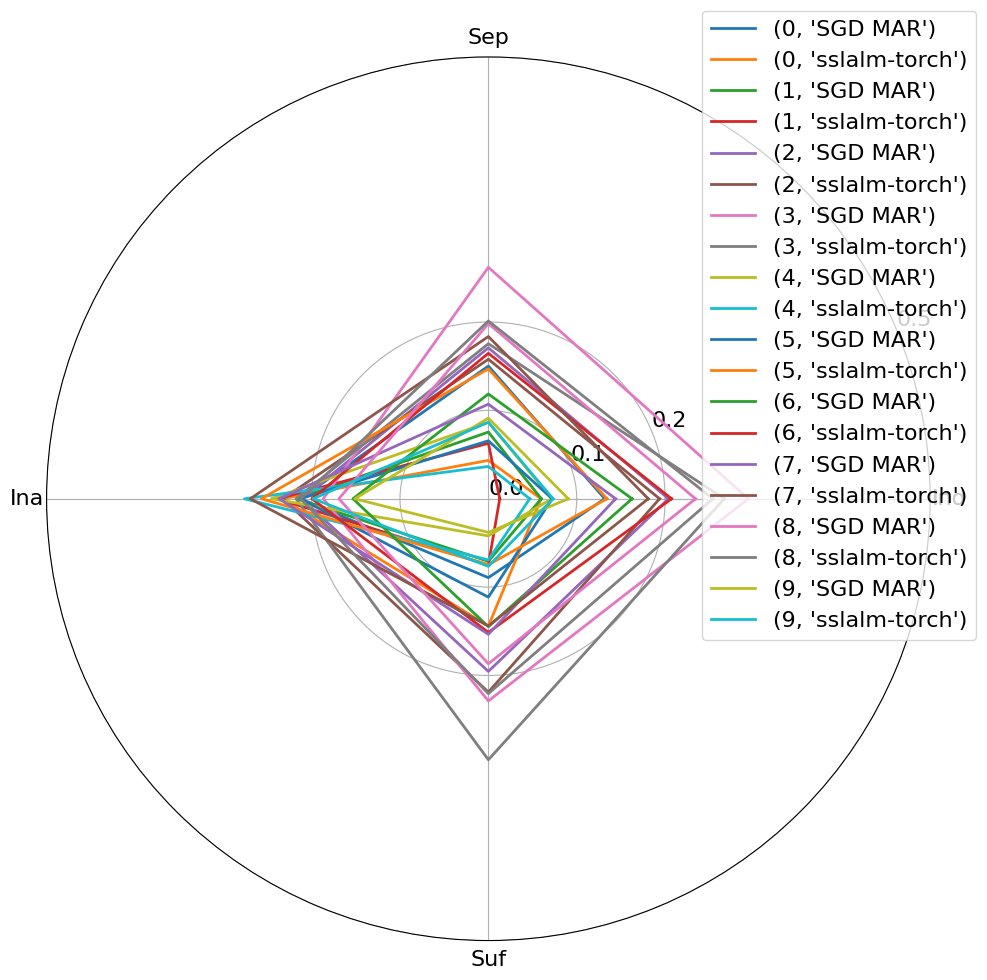

In [ ]:
from utils.plotting import spider_line


f = spider_line(train_df, yticks=[0,0.1,0.2,0.5])

**Distribution of predictions by group:**

In [ ]:
predictions_by_alg = {alg: {} for alg in set([model_name.split("_")[0] for model_name, _ in loaded_models])}


for i, group in enumerate(group_ind_test):
    for model_name, model in loaded_models:
        alg = model_name.split("_")[0]

        preds = torch.nn.functional.sigmoid(model(X_test_tensor[group])).detach().numpy().squeeze()
        try:
            predictions_by_alg[alg][i].append(preds)
        except:
            predictions_by_alg[alg][i] = [preds]

for alg in predictions_by_alg.keys():
    for i in predictions_by_alg[alg].keys():
        predictions_by_alg[alg][i] = np.concatenate(predictions_by_alg[alg][i])

In [ ]:
pred_dfs = {}

for alg, pred_dict in predictions_by_alg.items():
    preds = []
    groups = []
    for group, group_preds in pred_dict.items():
        preds.extend(group_preds)
        groups.extend([group]*len(group_preds))
    
    pred_dfs[alg] = (
        pd.DataFrame({'pred': preds, 'group': groups})
    )

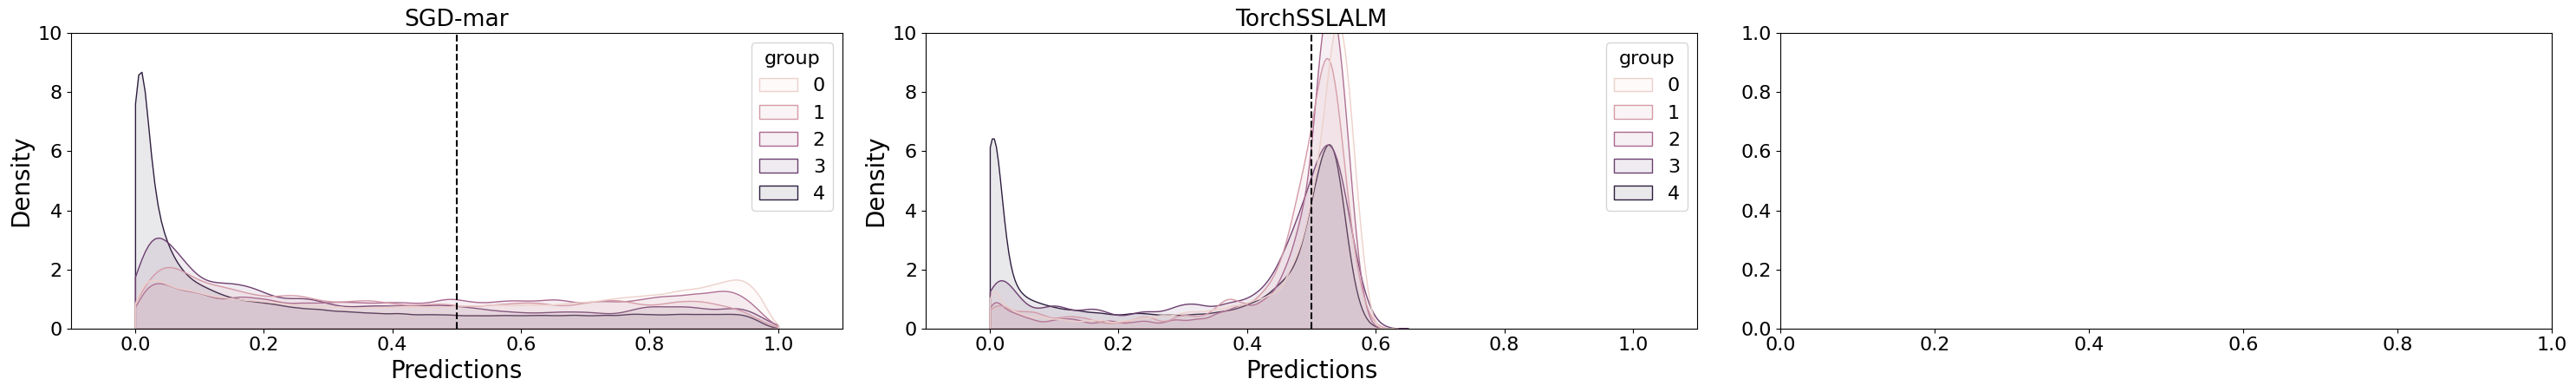

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=3)

for i, (alg, predictions) in enumerate(pred_dfs.items()):
    ax = axs[i]
    sns.kdeplot(
        predictions,
        x='pred',
        hue='group',
        fill=True,
        alpha=0.1,
        bw_adjust=0.4,
        ax=ax,
        clip=[0,1],
        common_norm=False)
    ax.vlines(0.5,0.,10, ls='--',color='black')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 10)
    ax.set_xlabel("Predictions", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    ax.set_title(alg)

fig.set_figwidth(30)
fig.tight_layout()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [ ]:
df_train.index.get_level_values('Algorithm').unique()

Index(['SGD MAR', 'sslalm-torch'], dtype='object', name='Algorithm')

In [ ]:
select_by = "AUC_M"

In [ ]:
best_models = {}
algs = df_train.index.get_level_values('Algorithm').unique()
for alg in algs:
    alg_df = df_train.xs(alg, level=1).reset_index()
    best_model_name = alg_df[['Model', select_by]].groupby('Model').mean()[select_by].idxmax()
    model = [(name, model) for name, model in loaded_models if name == best_model_name][0]
    best_models[alg] = model

#### Subgroup ROC

**TPR-FPR plot**

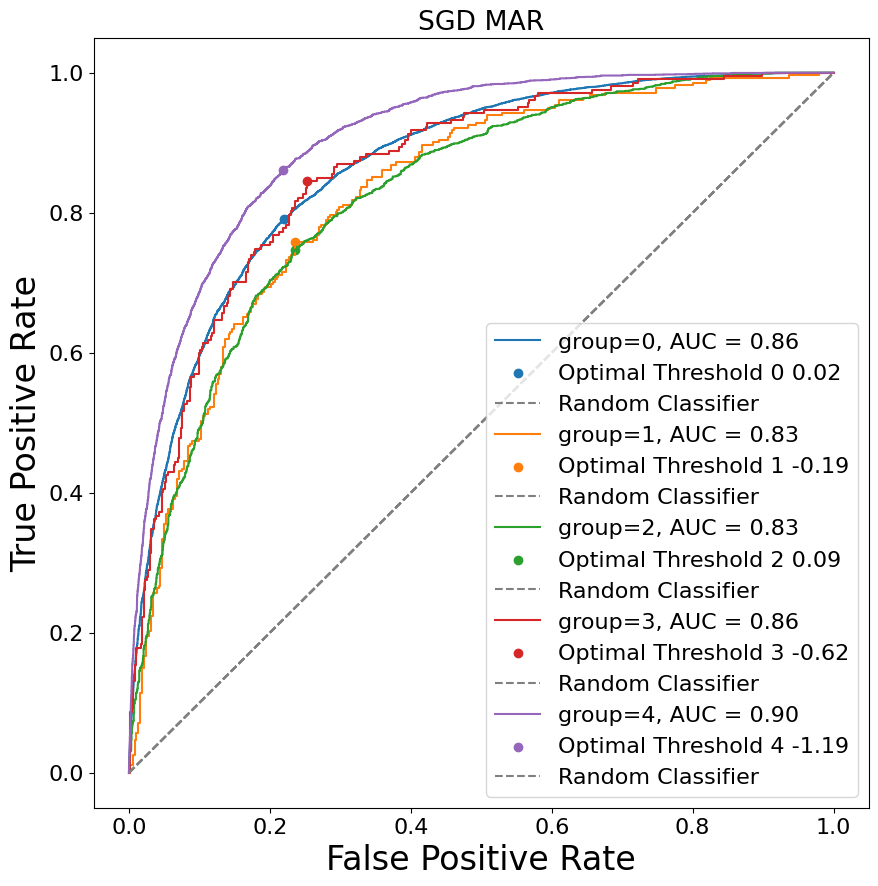

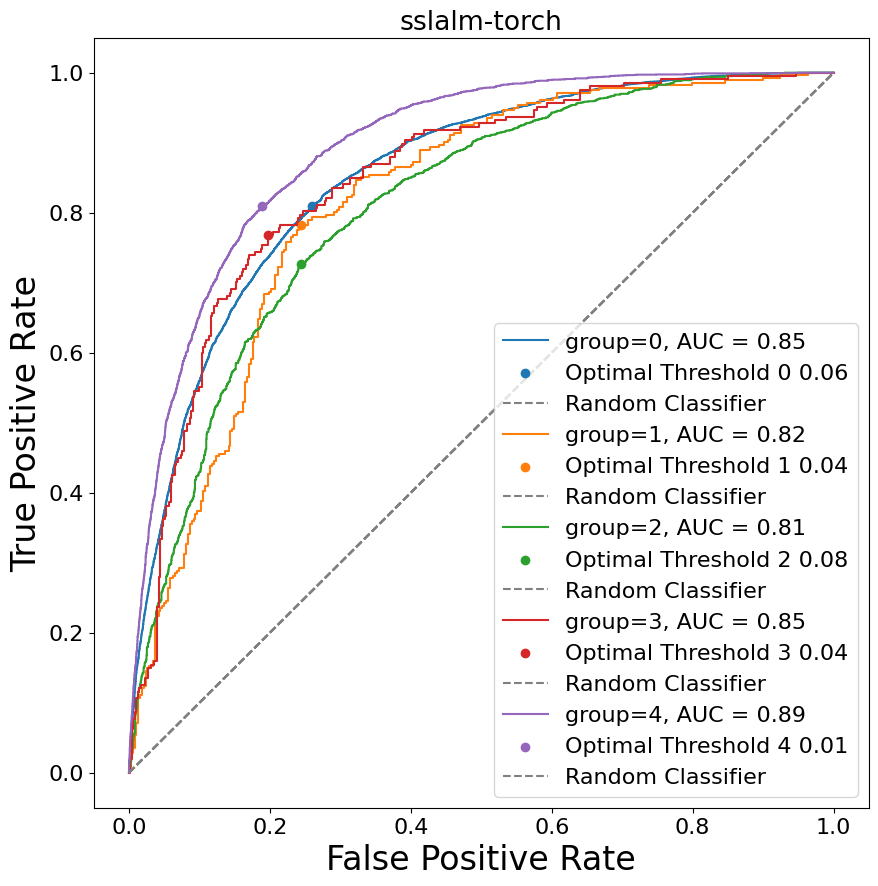

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"group={sensitive_value}, AUC = {roc_auc:.2f}")
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fpr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_pr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Positive Rate", fontsize=24)
            ax.set_ylabel("True Positive Rate", fontsize=24)
            ax.legend()

**TNR-FNR plot**

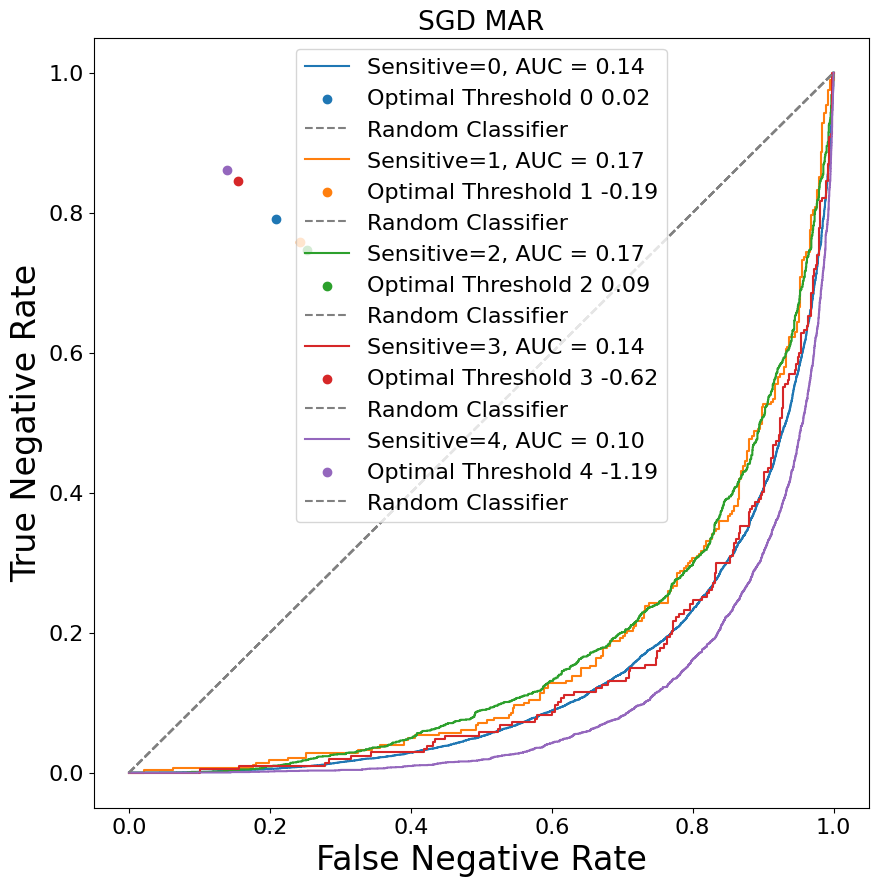

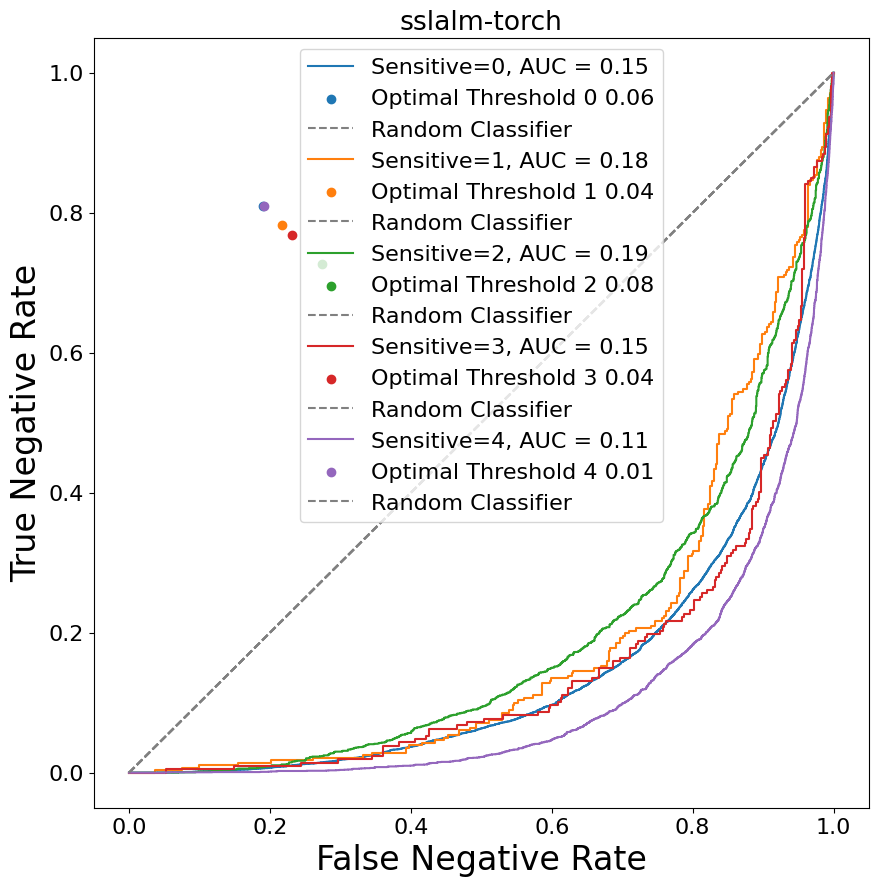

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    # predictions = predictions.detach().numpy()
    # targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = 1 - tpr
    tnr = 1 - fpr
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f"Sensitive={sensitive_value}, AUC = {roc_auc:.2f}")

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes tnr - fnr difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fnr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_nr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Negative Rate", fontsize=24)
            ax.set_ylabel("True Negative Rate", fontsize=24)
            ax.legend()